In [1]:
### allows to direct changes in the packages to be immidiately visibe in the notebook 
%load_ext autoreload
%autoreload 2

In [4]:
import os, sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

import packages.price_history as ph

In [6]:
file = '../data/index_price.csv'
df_quotes = pd.read_csv(file, sep = ';')
df_quotes.index = pd.to_datetime(df_quotes.Datetime)

ticker = '^GSPC'
df_data = df_quotes[df_quotes['Symbol']==ticker]

In [7]:
df_data

Datetime         Open         High  \
Datetime                                                             
2010-01-04 15:30:00  2010-01-04 15:30:00  1116.560059  1133.869995   
2010-01-05 15:30:00  2010-01-05 15:30:00  1132.660034  1136.630005   
2010-01-06 15:30:00  2010-01-06 15:30:00  1135.709961  1139.189941   
2010-01-07 15:30:00  2010-01-07 15:30:00  1136.270020  1142.459961   
2010-01-08 15:30:00  2010-01-08 15:30:00  1140.520020  1145.390015   
...                                  ...          ...          ...   
2020-08-10 15:30:00  2020-08-10 15:30:00  3356.040039  3363.290039   
2020-08-11 15:30:00  2020-08-11 15:30:00  3370.340088  3381.010010   
2020-08-12 15:30:00  2020-08-12 15:30:00  3355.459961  3387.889893   
2020-08-13 15:30:00  2020-08-13 15:30:00  3372.949951  3387.239990   
2020-08-14 15:30:00  2020-08-14 15:30:00  3368.659912  3378.510010   

                             Low        Close        Volume Symbol  \
Datetime                                                             
2010-01-04 15:30:00  1116.560059  1132.989990  3.991400e+09  ^GSPC   
2010-01-05 15:30:00  1129.660034  1136.520020  2.491020e+09  ^GSPC   
2010-01-06 15:30:00  1133.949951  1137.140015  4.972660e+09  ^GSPC   
2010-01-07 15:30:00  1131.319946  1141.689941  5.270680e+09  ^GSPC   
2010-01-08 15:30:00  1136.219971  1144.979980  4.389590e+09  ^GSPC   
...                          ...          ...           ...    ...   
2020-08-10 15:30:00  3335.439941  3360.469971  4.318570e+09  ^GSPC   
2020-08-11 15:30:00  3326.439941  3333.689941  5.087650e+09  ^GSPC   
2020-08-12 15:30:00  3355.459961  3380.350098  3.768560e+09  ^GSPC   
2020-08-13 15:30:00  3363.350098  3373.429932  3.648810e+09  ^GSPC   
2020-08-14 15:30:00  3361.639893  3372.850098  3.193400e+09  ^GSPC   

                       Adj_Close  
Datetime                          
2010-01-04 15:30:00  1132.989990  
2010-01-05 15:30:00  1136.520020  
2010-01-06 15:30:00  1137.140015  
2010-01-07 15:30:00  1141.689941  
2010-01-08 15:30:00  1144.979980  
...                          ...  
2020-08-10 15:30:00  3360.469971  
2020-08-11 15:30:00  3333.689941  
2020-08-12 15:30:00  3380.350098  
2020-08-13 15:30:00  3373.429932  
2020-08-14 15:30:00  3372.850098  

[2673 rows x 8 columns]

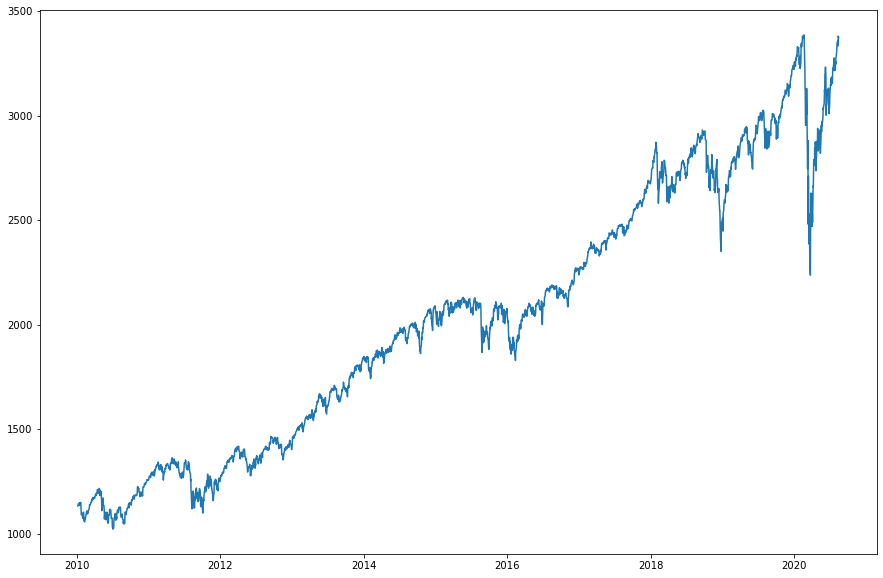

In [8]:
fig = plt.figure(figsize=(15, 10))
plt.plot(df_data.index, df_data.Adj_Close)

### Lets drop the market crash due to corona lockdown 

In [9]:
df_data = df_data[df_data['Datetime']<"2020-02"]

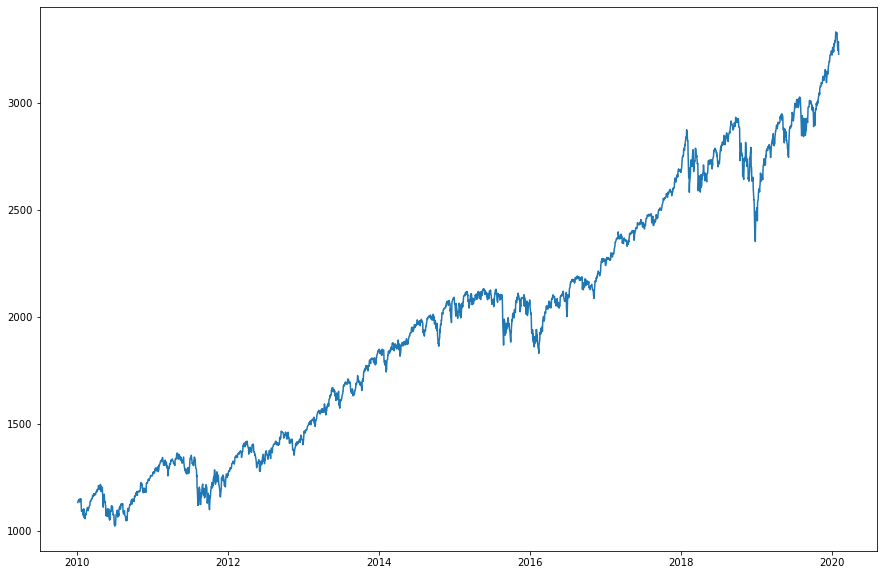

In [10]:
fig = plt.figure(figsize=(15, 10))
plt.plot(df_data.index, df_data.Adj_Close)

In [11]:
df_X = df_data.dropna(inplace=True)
df_X = df_data.drop(['Datetime', 'Close', 'Volume', 'Symbol', 'Adj_Close'], axis=1)
df_y = df_data['Close']
df_X.shape, df_y.shape

C:\ProgramData\Anaconda3\envs\algo_trading\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


((2537, 3), (2537,))

In [12]:
df_data.isna().sum()

Datetime     0
Open         0
High         0
Low          0
Close        0
Volume       0
Symbol       0
Adj_Close    0
dtype: int64

In [13]:
test_window = 7 ### days ahead forecast
max_rows = df_X.shape[0]

df_train_X = df_X[0:max_rows-test_window]
df_test_X = df_X[max_rows-test_window:max_rows]
df_train_X.shape, df_test_X.shape

df_train_y = df_y[0:max_rows-test_window]
df_test_y = df_y[max_rows-test_window:max_rows]

df_train_X.shape, df_train_y.shape, df_test_X.shape, df_test_y.shape


((2530, 3), (2530,), (7, 3), (7,))

## GPR is defined by its kernels
#### The kernel 𝑘(𝐱, 𝐱′) species which structures are likely under the GP prior, which in turn determines the generalization properties of the model. Commonly used kernels families include the squared exponential (SE), periodic (Per), linear (Lin), and rational quadratic (RQ).

### Composite Kernels 
#### Positive semidefinite kernels (i.e. those which define valid covariance functions) are closed under addition and multiplication. This allows one to create richly structured and interpretable kernels from well understood base components. Kernels over multidimensional inputs are constructed by adding and multiplying kernels over individual dimensions.

#### By summing kernels, we can model the data as a superposition of independent functions, possibly representing different structures. I.e., for GP priors 𝑓1 ∼ 𝒢𝒫(𝜇1, 𝑘1), 𝑓2 ∼ 𝒢𝒫(𝜇2, 𝑘2) 𝑓 ≔ 𝑓1 + 𝑓2 ∼ 𝒢𝒫(𝜇1 + 𝜇2, 𝑘1 + 𝑘2)

#### Multiplying kernels allows us to account for interactions between different input dimensions or different notions of similarity. For instance, in multidimensional data, the multiplicative kernel SE1 × SE3 represents a smoothly varying function of dimensions 1 and 3 which is not constrained to be additive. In univariate data, multiplying a kernel by SE gives a way of converting global structure to local structure. For example, PER corresponds to globally periodic structure, whereas PER × SE corresponds to locally periodic structure. 

#### For further details on GPR please review the following paper
#### Duvenaud, D., Lloyd, J., Grosse, R., Tenenbaum, J. & Zoubin, G.. (2013). Structure Discovery in Nonparametric Regression through Compositional Kernel Search. Proceedings of the 30th International Conference on Machine Learning, in PMLR 28(3):1166-1174

#### Our first choice of kernels is the following

In [15]:
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
# medium term irregularity
k2 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.1)
k3 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 

#### Lets fit the model

In [16]:
gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(df_train_X, df_train_y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


GPML kernel: 66**2 * RBF(length_scale=67) + 0.66**2 * RationalQuadratic(alpha=0.1, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: -1815.454


In [17]:
y_pred = gp.predict(df_test_X, return_std=False)

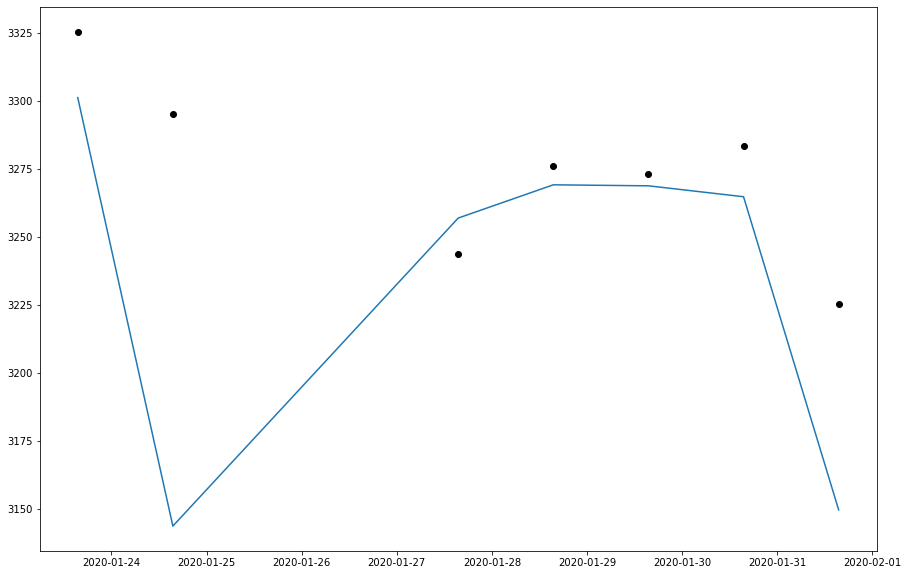

In [18]:
# Illustration
fig = plt.figure(figsize=(15, 10))
plt.scatter(df_test_y.index, df_test_y.values, c='k')
plt.plot(df_test_y.index, y_pred)

In [19]:
### MSE

In [20]:
mean_squared_error(y_pred, df_test_y.values)

4290.360658321315

### Percentage drift on daily basis

In [21]:
(y_pred-df_test_y.values)/df_test_y.values*100

array([-0.7271052 , -4.60931694,  0.41194502, -0.21366716, -0.13846162,
       -0.57289002, -2.3555302 ])

### lets alpha for these kernels now

In [22]:
# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
# medium term irregularities
k2 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k3 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel_gpml = k1 + k3 + k3 


gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0.1,
                              optimizer=None, normalize_y=True)
gp.fit(df_train_X, df_train_y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


GPML kernel: 50**2 * RBF(length_scale=50) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
Log-marginal-likelihood: -2525.708


In [23]:
#y_pred, y_std = gp.predict(df_test_X, return_std=True)
y_pred = gp.predict(df_test_X, return_std=False)

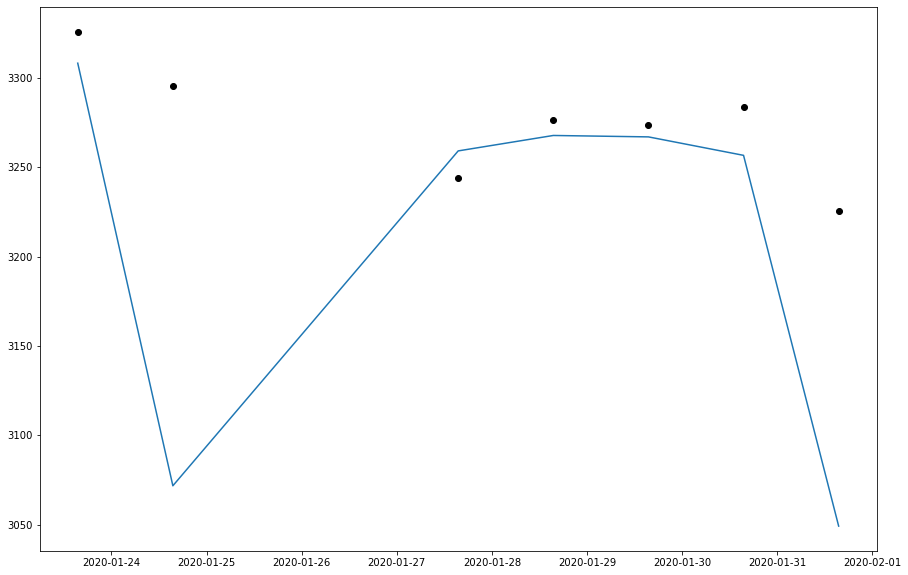

In [24]:
# Illustration
fig = plt.figure(figsize=(15, 10))
plt.scatter(df_test_y.index, df_test_y.values, c='k')
plt.plot(df_test_y.index, y_pred)

In [26]:
### percentage drift
(y_pred-df_test_y.values)/df_test_y.values*100

array([-0.52554722, -6.78592727,  0.47466165, -0.26208261, -0.19975253,
       -0.82576032, -5.46308304])

In [25]:
mean_squared_error(y_pred, df_test_y.values)

11779.24971730202

### MSE is increased, the kernel functions can be adjusted to furhter improve the error. Checkout the optimimum kernel discovery method mentioned here
### https://github.com/jamesrobertlloyd/gp-structure-search